# Predicting House Prices

## Importing dependencies & Options setting

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
sns.set_style("dark")

In [31]:
data = pd.read_csv('data_scientist_test/house_sales.csv')

assert data.isna().sum().sum()==0
print('No missing values')

No missing values


## Data Exploring

#### Data description

In [32]:
print("Minimum price: {:,.2f}".format(data['price'].min()))
print("Maximum price: {:,.2f}".format(data['price'].max()))
print("Standard deviation of prices: ${:,.2f}".format(data['price'].std()))
print("Price quartiles: {:,.2f} | {:,.2f} | {:,.2f}".format(data['price'].quantile(0.25), data['price'].quantile(0.5), data['price'].quantile(0.75)))

Minimum price: 78,000.00
Maximum price: 7,700,000.00
Standard deviation of prices: $372,013.52
Price quartiles: 321,837.50 | 450,000.00 | 648,000.00


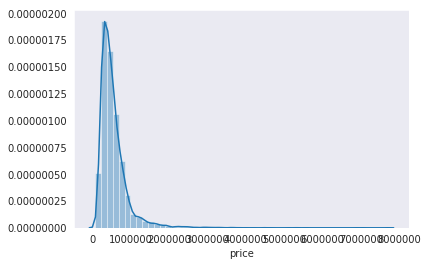

In [48]:
sns.distplot(data['price']);

In [50]:
data.sort_values('price').tail(10)

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
7363,4489000,4,3.000,6430,27517,2.000,0,3,0,2001,0,98004,47.621,-122.219,3720,14592
2222,4500000,5,5.500,6640,40014,2.000,1,3,290,2004,0,98155,47.749,-122.280,3030,23408
6899,4668000,5,6.750,9640,13068,1.000,1,3,4820,1983,2009,98040,47.557,-122.210,3270,10454
982,5110800,5,5.250,8010,45517,2.000,1,3,2020,1999,0,98033,47.677,-122.211,3430,26788
1115,5300000,6,6.000,7390,24829,2.000,1,4,2390,1991,0,98040,47.563,-122.210,4320,24619
1228,5350000,5,5.000,8000,23985,2.000,0,3,1280,2009,0,98004,47.623,-122.220,4600,21750
3755,5570000,5,5.750,9200,35069,2.000,0,3,3000,2001,0,98039,47.629,-122.233,3560,24345
7894,6885000,6,7.750,9890,31374,2.000,0,3,1030,2001,0,98039,47.630,-122.240,4540,42730
3330,7062500,5,4.500,10040,37325,2.000,1,3,2360,1940,2001,98004,47.650,-122.214,3930,25449
6178,7700000,6,8.000,12050,27600,2.500,0,4,3480,1910,1987,98102,47.630,-122.323,3940,8800


The target distribution is very skewed and raises the attention for outliers. 

When checking the largest values though, it doesn't seem that any datapoint has a completly abnormal value. In fact, house prices distributions must look just like the one above. I decided to move on with the whole dataset.

In [51]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,18448.000,542362.371,372013.519,78000.000,321837.500,450000.000,648000.000,7700000.000
num_bed,18448.000,3.373,0.934,0.000,3.000,3.000,4.000,33.000
num_bath,18448.000,2.119,0.772,0.000,1.750,2.250,2.500,8.000
size_house,18448.000,2083.941,921.416,290.000,1430.000,1920.000,2560.000,13540.000
size_lot,18448.000,15036.024,41814.549,520.000,5050.000,7600.500,10625.250,1651359.000
num_floors,18448.000,1.495,0.541,1.000,1.000,1.500,2.000,3.500
is_waterfront,18448.000,0.008,0.087,0.000,0.000,0.000,0.000,1.000
condition,18448.000,3.412,0.653,1.000,3.000,3.000,4.000,5.000
size_basement,18448.000,293.571,443.608,0.000,0.000,0.000,570.000,4820.000
year_built,18448.000,1971.001,29.362,1900.000,1952.000,1975.000,1997.000,2015.000


#### Sizes and prices

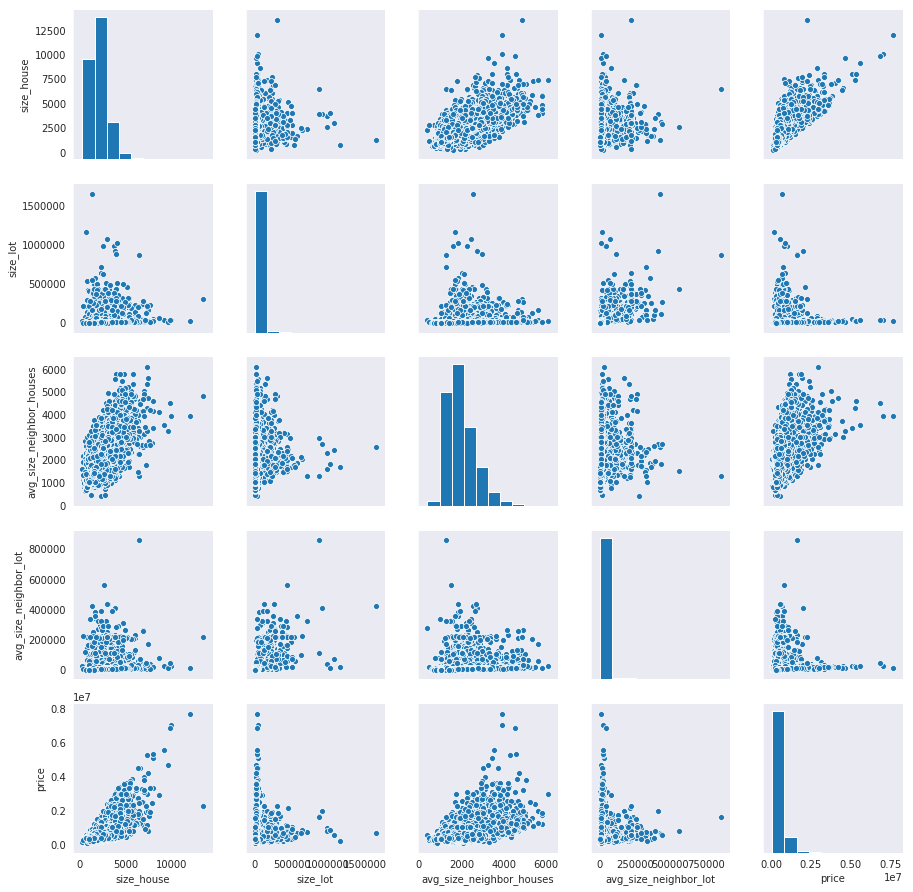

In [52]:
sns.pairplot(data, vars=['size_house', 'size_lot', 'avg_size_neighbor_houses', 'avg_size_neighbor_lot', 'price']);

The distribution of features related to sizes are very skewed too. Although this is also expected, very large feature values might have an undesirable impact on our model. It is better to rescale those features.

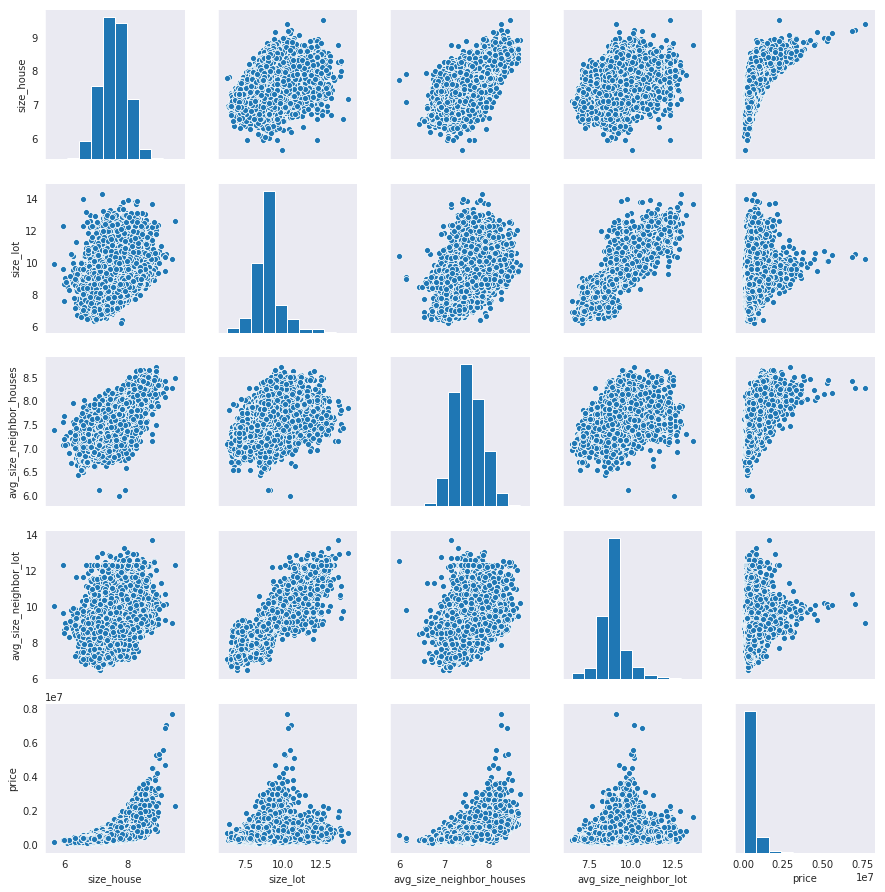

In [53]:
sns.pairplot(pd.concat([
    data[['size_house', 'size_lot', 'avg_size_neighbor_houses', 'avg_size_neighbor_lot']].apply(np.log),
    data['price']], axis=1));

I have used log scaling to features related to size. Another way to think of log scaling these features is that one unit of size should have greater impact on an small property compared com the same unit of size affecting a really large property. In other words, the price per unit of size should be lower for bigger houses, ceteris paribus.

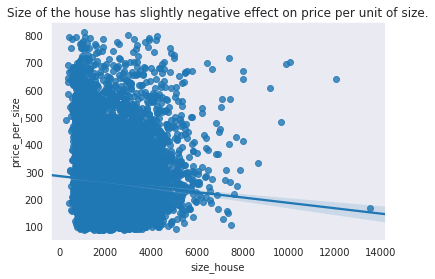

In [58]:
data['price_per_size'] = data['price'] / data['size_house']
sns.regplot(x='size_house', y='price_per_size', data=data);
plt.title('Size of the house has slightly negative effect on price per unit of size.');

In [63]:
data['has_basement'] = data['size_basement']>0
print('{}% of the houses have basement.'.format((data.has_basement.mean()*100).round(1)))

39.4% of the houses have basement.


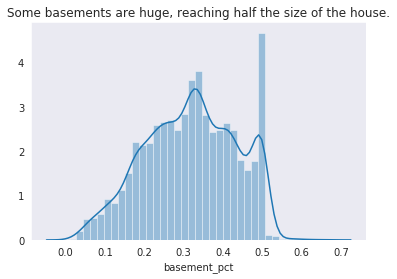

In [64]:
data['basement_pct'] = data['size_basement'] / data['size_house']
sns.distplot(data[data.has_basement].basement_pct);
plt.title('Some basements are huge, reaching half the size of the house.');

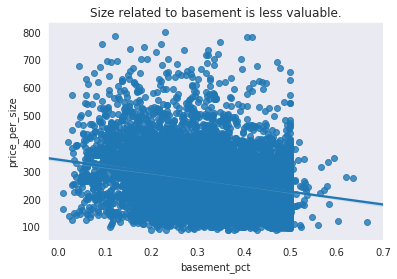

In [65]:
sns.regplot(x='basement_pct', y='price_per_size', data=data[data.has_basement]);
plt.title('Size related to basement is less valuable.');

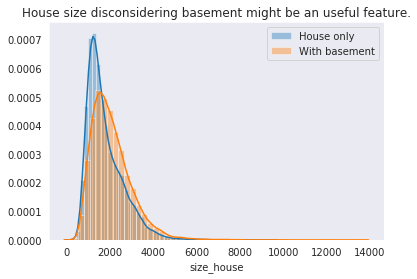

In [66]:
data['house_minus_basement'] = data['size_house'] - data['size_basement']
sns.distplot(data.house_minus_basement, label='House only');
sns.distplot(data.size_house, label='With basement');
plt.legend();
plt.title('House size disconsidering basement might be an useful feature.');

#### House settings

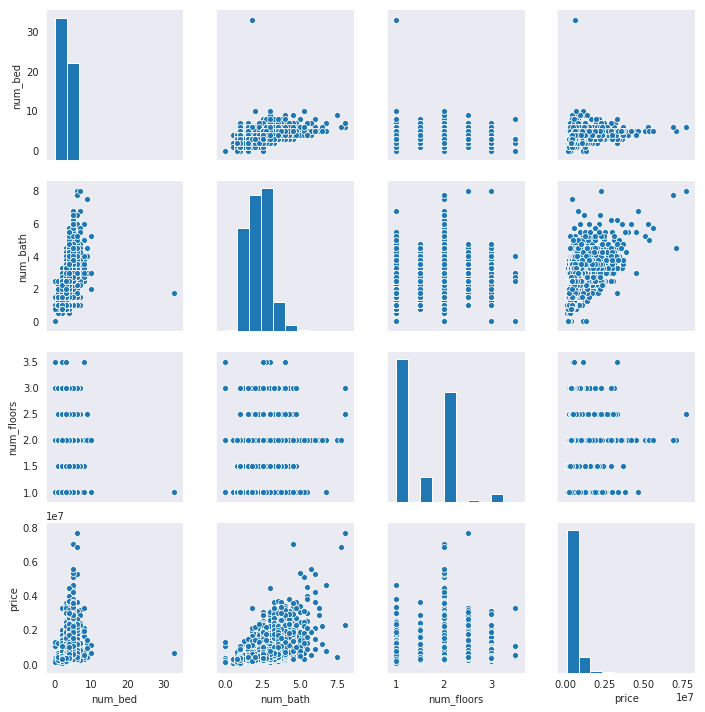

In [12]:
sns.pairplot(data, vars=['num_bed', 'num_bath', 'num_floors', 'price']);

There's one house with an extremaly large num_bed that is distorting this feature. Let's treat this datapoint as an outlier and drop it.

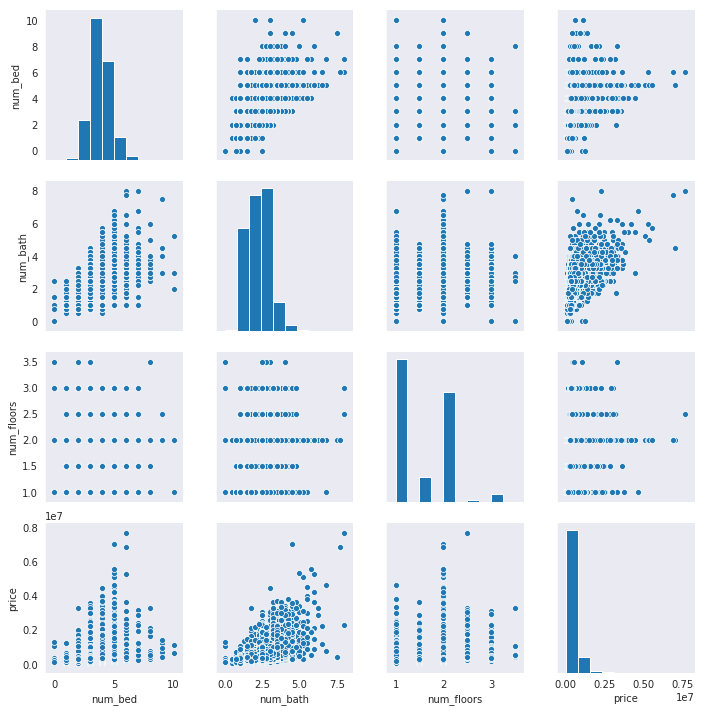

In [13]:
data = data[data.num_bed<20]
sns.pairplot(data, vars=['num_bed', 'num_bath', 'num_floors', 'price']);

Distributions look better now.

One interesting thing to notice is that the most expensive houses are not the ones with large number of floors or bedrooms. It gives an idea of amplitude and we can think of bedroom size to measure this.

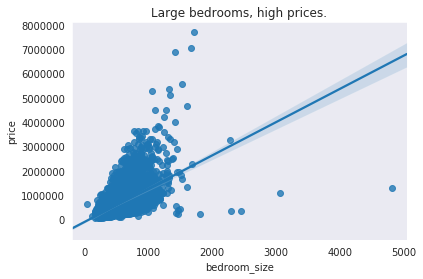

In [74]:
data['bedroom_size'] = data['size_house'] / (data['num_bed'] + 1)
sns.regplot(data=data, x='bedroom_size', y='price');
plt.title('Large bedrooms, high prices.');

#### Conditions and renovations

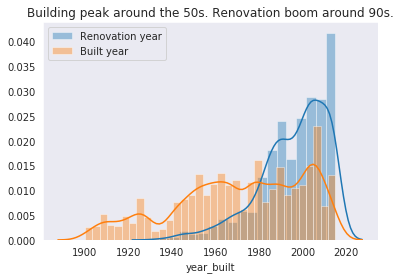

In [77]:
data['was_renovated'] = data.renovation_date>0

sns.distplot(data[data.was_renovated].renovation_date, label='Renovation year')
sns.distplot(data.year_built, label='Built year')
plt.legend();
plt.title('Building peak around the 50s. Renovation boom around 90s.');

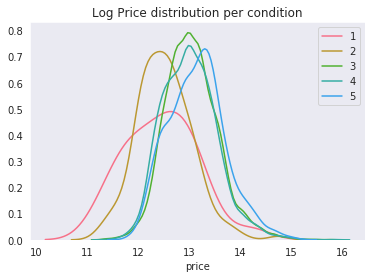

In [79]:
with sns.color_palette("husl"):
    for condition in [1,2,3,4,5]:
        sns.distplot(data[data.condition==condition]['price'].apply(np.log), hist=False, label=condition)
plt.title('Log Price distribution per condition');

In general, better condition means higher prices. But the negative impact of a very worn out house is higher than the impact of a perfect condition.

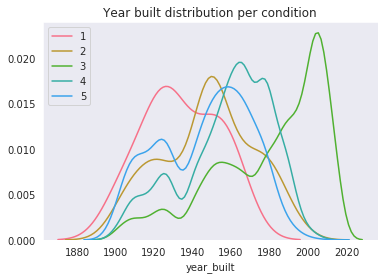

In [80]:
with sns.color_palette("husl"):
    for condition in [1,2,3,4,5]:
        sns.distplot(data[data.condition==condition]['year_built'], hist=False, label=condition)
plt.title('Year built distribution per condition');

In general, older houses are more degraded, but the newest ones don't usually have the best condition.

#### Locastion properties

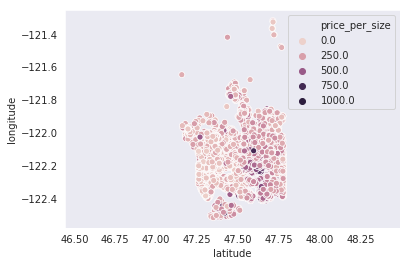

In [17]:
sns.scatterplot(x="latitude", y="longitude", hue="price_per_size", data=data);
plt.axis('equal');

Prices per unit of size are higher somewhere near the middle of the city and also on the island-like region at the bottom.

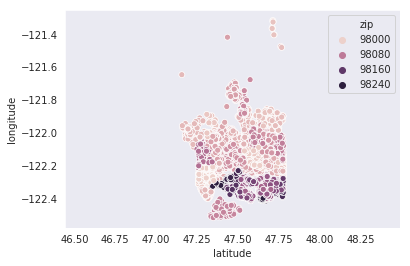

In [18]:
sns.scatterplot(x="latitude", y="longitude", hue="zip", data=data);
plt.axis('equal');

In [91]:
print('There are {} different zip numbers.'.format(len(set(data.zip))))

There are 70 different zip numbers.


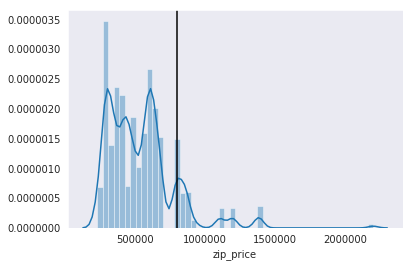

In [122]:
data['zip_price'] = data.groupby('zip').transform(np.mean)['price']
sns.distplot(data.zip_price)
plt.axvline(800000, color='black');

Some zip regions have an extremely high mean price.

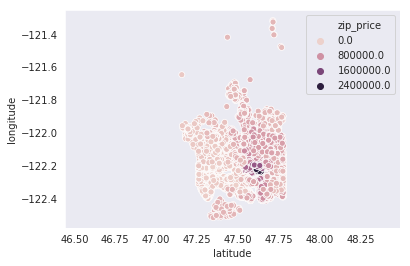

In [92]:
sns.scatterplot(x="latitude", y="longitude", hue="zip_price", data=data);
plt.axis('equal');

Zip regions with high average price cluster together near the middle of the city.

In [123]:
expensive_zips = list(set(data[data.zip_price>800000]['zip']))
expensive_zips

[98112, 98119, 98039, 98004, 98005, 98102, 98006, 98040, 98105, 98109]

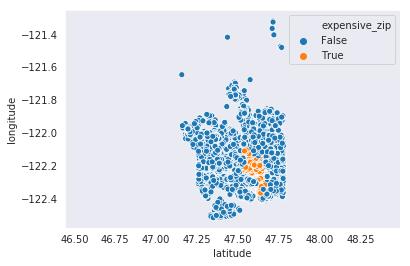

In [124]:
data['expensive_zip'] = data.zip.isin(expensive_zips)

sns.scatterplot(x="latitude", y="longitude", hue="expensive_zip", data=data);
plt.axis('equal');

I have tagged the regions in which the mean price is highr than 800.000,00.

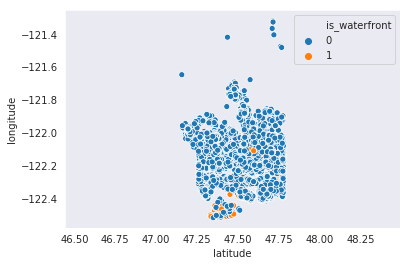

In [125]:
sns.scatterplot(x="latitude", y="longitude", hue="is_waterfront", data=data);
plt.axis('equal');

In [126]:
print('In average, waterfront houses are {:.2} times more expensive than other properties in the same zip code region.'.format(
    (data[data.is_waterfront==1]['price']/ data[data.is_waterfront==1]['zip_price']).mean()));

In average, waterfront houses are 2.9 times more expensive than other properties in the same zip code region.


## Processing Data

In [128]:
def process_data(df):
    if 'price' in df.columns:
        y = df['price']
        df = df.drop('price', axis=1)
    else:
        y=None
    
    # extra features
    df['has_basement'] = (df['size_basement']>0).astype(int)
    df['basement_pct'] = df['size_basement'] / df['size_house']
    df['house_minus_basement'] = df['size_house'] - df['size_basement']
    df['bedroom_size'] = df['size_house'] / (df['num_bed'] + 1)
    df['was_renovated'] = (df.renovation_date>0).astype(int)
    expensive_zips = [98112, 98119, 98039, 98004, 98005, 98102, 98006, 98040, 98105, 98109]
    df['expensive_zip'] = (df.zip.isin(expensive_zips)).astype(int)
    
    # log scaling sizes
    sizes = ['size_house', 'size_lot', 'avg_size_neighbor_houses', 'avg_size_neighbor_lot']
    df[sizes] = df[sizes].apply(np.log)
    
    # min_max_scaler
    scaler = MinMaxScaler()
    X = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    return X, y

In [129]:
df = pd.read_csv('data_scientist_test/house_sales.csv')
X, y = process_data(df)

### Feature Importances

In [130]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=10, min_samples_leaf=4, 
                           max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(X, y)
importances = pd.DataFrame({'feature':X.columns, 'importance':rf.feature_importances_}).sort_values('importance', ascending=False).set_index('feature')

In [148]:
importances.head(10)

,importance
feature,
size_house,0.211
bedroom_size,0.127
latitude,0.117
house_minus_basement,0.103
expensive_zip,0.095
avg_size_neighbor_houses,0.090
num_bath,0.064
longitude,0.040
is_waterfront,0.030


## Training models

I'm using the coefficient of determination, R2, to quantify models' performances. The R2 is a very popular statistic in regression models because it describes how good that model is at making predictions.

The values for R2 range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the target variable. A model with an R2 of 0 is no better than a model that always predicts the mean of the target variable, whereas a model with an R2 of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the features. A model can be given a negative R2 as well, which indicates that the model is arbitrarily worse than one that always predicts the mean of the target variable.*

*_Explation extracted from an Udacity Machine Learning course project._

#### Linear Regression

R2 for Linear Regression model, calculated using cross validation with 3 folds.

In [149]:
lr = LinearRegression(n_jobs=-1)
np.mean(cross_val_score(lr, X, y, cv=3, scoring='r2'))

0.739907007941353

#### Random Forest Regressor

R2 for Random Forest model, calculated using cross validation with 3 folds and optimized using sklarn's GridSearch.

In [134]:
rf = RandomForestRegressor(n_estimators=1000,n_jobs=-1, random_state=1)

rf_parameters = {'max_depth': [3, 6, 9, 15],
                 'min_samples_leaf': [2, 10, 100]}

rf_grid_obj = GridSearchCV(rf, rf_parameters, scoring='r2', verbose=1, cv=3)
rf_grid_obj = rf_grid_obj.fit(X, y)

rf_opt =  rf_grid_obj.best_estimator_
rf_grid_obj.best_score_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 10.3min finished


0.8541424807738226

#### KNN Regressor

R2 for KNN regressor. 

KNN works by comparing each datapoint with the ones that are closer to it in the feature space. I decided to create a regular loop instead of using GridSearch for KNN Regressor to also iterate over multiple feature spaces, ranging from 3 to 15 most important features.

In [135]:
d = {}
for n in [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    for f in range(3,15):
        for w in ['distance', 'uniform']:
            reg = KNeighborsRegressor(n_jobs=-1, n_neighbors=n)
            score = np.mean(cross_val_score(reg, X[importances.head(f).index.tolist()], y, cv=3, scoring='r2'))
            d[(n,f,w)] = score

best_knn = max(d.keys(), key=(lambda k: d[k]))
d[best_knn]

0.8196334427697852

### Fitting and saving the best model

In [136]:
rf_opt.fit(X,y)

with open('model.pkl', 'wb') as f:
    pickle.dump(rf_opt, f)

## Making Predictions

In [9]:
import pandas as pd, seaborn as sns,  numpy as np, pickle, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

def process_data(train_path, test_path):
    train = pd.read_csv(train_path)
    y_train = train['price']
    train = train.drop('price', axis=1)

    test = pd.read_csv(test_path)
    if 'price' in test.columns:
        y_test = test['price']
        test = test.drop('price', axis=1)
    else:
        y_test=None

    expensive_zips = [98112, 98119, 98039, 98004, 98005, 98102, 98006, 98040, 98105, 98109]
    sizes = ['size_house', 'size_lot', 'avg_size_neighbor_houses', 'avg_size_neighbor_lot']
    
    for df in [train, test]:
        df['has_basement'] = (df['size_basement']>0).astype(int)
        df['basement_pct'] = df['size_basement'] / df['size_house']
        df['house_minus_basement'] = df['size_house'] - df['size_basement']
        df['bedroom_size'] = df['size_house'] / (df['num_bed'] + 1)
        df['was_renovated'] = (df.renovation_date>0).astype(int)
        df['expensive_zip'] = (df.zip.isin(expensive_zips)).astype(int)
        df[sizes] = df[sizes].apply(np.log)
    
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    X_test = pd.DataFrame(scaler.transform(df), columns=df.columns)
    
    return X_train, y_train, X_test, y_test

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [7]:
# change directory and file below
train_path = 'house_sales.csv'
test_path = ''

X_train, y_train, X_test, y_test = process_data(train_path, test_path)
y_pred = model.predict(X_test)
pd.DataFrame(y_pred, columns=['y_pred']).to_csv('predictions.csv')